In [25]:
#Data Manipulation
import pandas as pd
import numpy as np

# Plots
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

#Others
import os
import holidays
from statsmodels.tsa.seasonal import seasonal_decompose

# apartado ts
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

#Parameters Dict
parameters = {
    "paths": {
        "2022_01_06": "../data/data_casal_montserratina/Casal_Montserratina_202201_202206.csv",
        "2022_07_12": "../data/data_casal_montserratina/Casal_Montserratina_202207_202212.csv",
        "2023_01_06": "../data/data_casal_montserratina/Casal_Montserratina_202301_202306.csv",
        "2023_07_12": "../data/data_casal_montserratina/Casal_Montserratina_202307_202312.csv",
        "2024_01_05": "../data/data_casal_montserratina/Casal_Montserratina_202401_202405.csv",
    }
}

In [26]:
ruta_data = "../data/data_casal_montserratina/"

In [27]:
df1 = pd.read_csv(parameters["paths"]["2022_01_06"], delimiter=";")
df2 = pd.read_csv(parameters["paths"]["2022_07_12"], delimiter=";")
df3 = pd.read_csv(parameters["paths"]["2023_01_06"], delimiter=";")
df4 = pd.read_csv(parameters["paths"]["2023_07_12"], delimiter=";")
df5 = pd.read_csv(parameters["paths"]["2024_01_05"], delimiter=";")

In [28]:
# hago un concat de los 4 datasets, para Unir los DataFrames uno a continuación del otro
df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
df["TimeStamp"] = pd.to_datetime(df["TimeStamp"], format="%d/%m/%Y %H:%M")
df = df.drop(columns=["Tipus lectura", "Període tarifari"])
df.rename(columns={'TimeStamp': 'Date', 
                   'Valor': 'Consumo'}, inplace=True)
df.head()

,Date,Consumo
0,2022-01-01 00:00:00,6
1,2022-01-01 01:00:00,6
2,2022-01-01 02:00:00,5
3,2022-01-01 03:00:00,7
4,2022-01-01 04:00:00,7


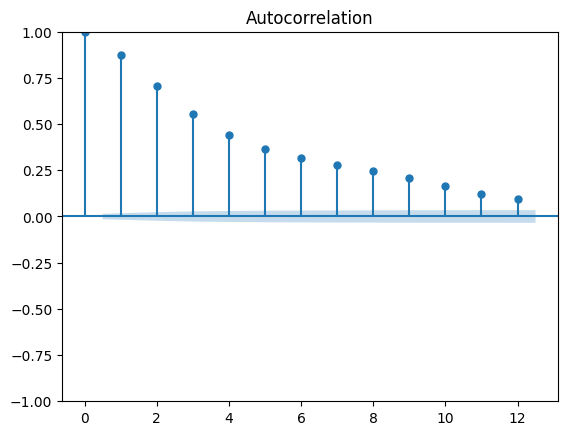

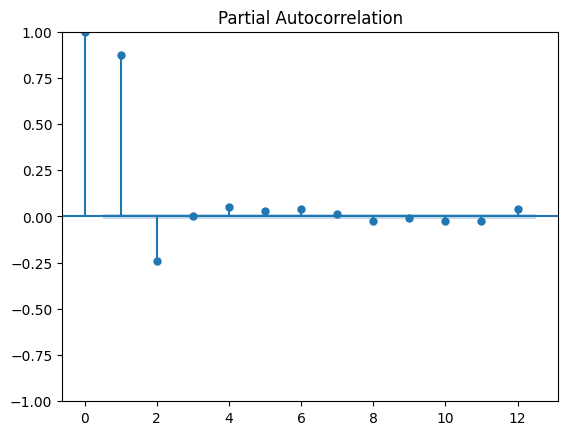

In [29]:
LAGS = 

# ver si es estacionaria
acf_original = plot_acf(df["Consumo"], lags=LAGS)
pacf_original = plot_pacf(df["Consumo"], lags=LAGS)

In [30]:
adf_test = adfuller(df["Consumo"])
print(f"p-value: {adf_test[1]}")	

p-value: 3.1852139831667153e-15


Dado que el p-value es mucho menor que 0.05, se puede concluir que la serie temporal "Consumo" es estacionaria.

In [31]:
# podemos reducir la varianza de una STU **utilizando el logaritmo.**
df["Consumo_log"] = df["Consumo"].apply(np.log1p)
df["Consumo_log_diff"] = df["Consumo_log"].diff()

In [32]:
# adf_test = adfuller(df["Consumo_log_diff"])
# print(f"p-value: {adf_test[1]}")

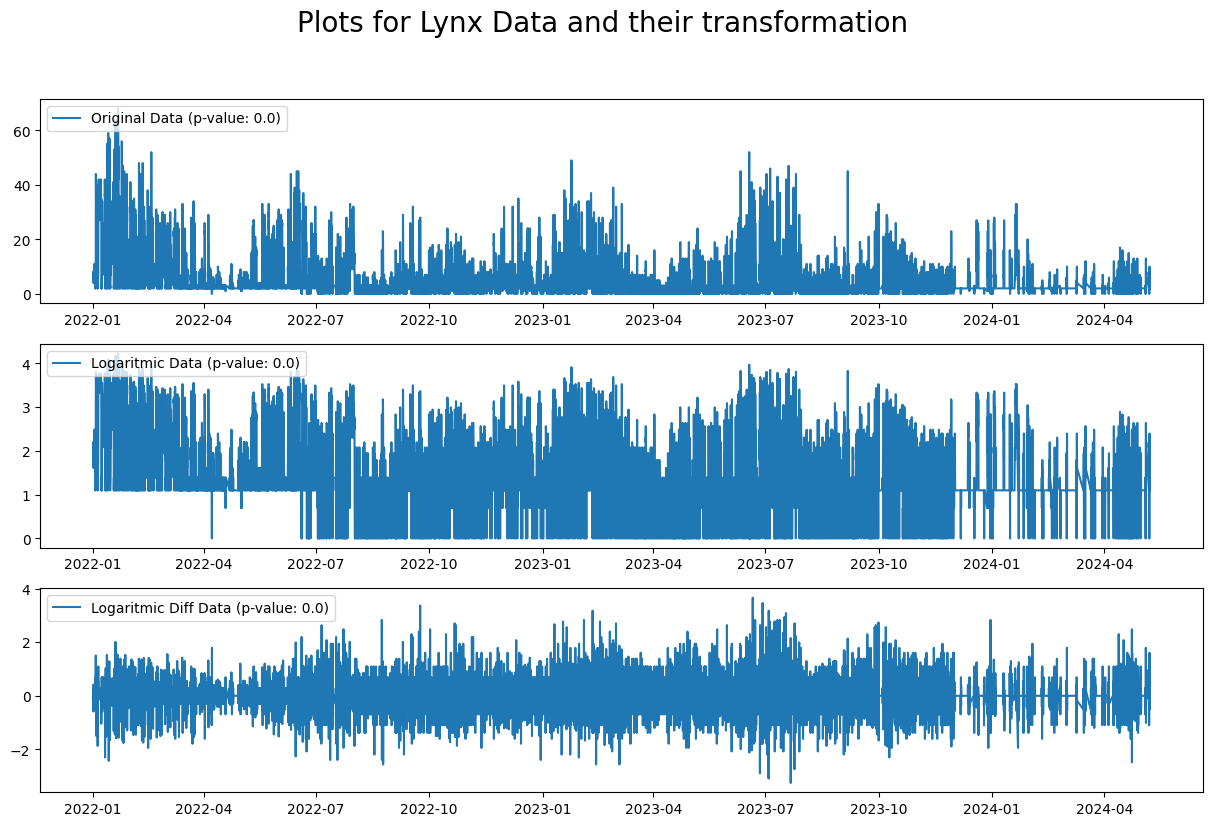

In [33]:
# instanciate the figure
fig = plt.figure(figsize = (15, 9))
ax1, ax2, ax3 = fig.subplots(3, 1)

# select x and y to plot
df_x = df["Date"]

df_y = df["Consumo"]
df_y_log = df["Consumo_log"]
df_y_log_diff = df["Consumo_log_diff"]

# plotting part
ax1.plot(df_x, df_y, label = f"Original Data (p-value: {round(adfuller(df_y)[1], 4)})")
ax2.plot(df_x, df_y_log, label = f"Logaritmic Data (p-value: {round(adfuller(df_y_log)[1], 4)})")
ax3.plot(df_x, df_y_log_diff, label = f"Logaritmic Diff Data (p-value: {round(adfuller(df_y_log_diff.dropna())[1], 4)})"
)

ax1.legend(loc = "upper left")
ax2.legend(loc = "upper left")
ax3.legend(loc = "upper left")

fig.suptitle("Plots for Lynx Data and their transformation", fontsize = 20);

In [34]:
df_y_log_diff.dropna(inplace = True)

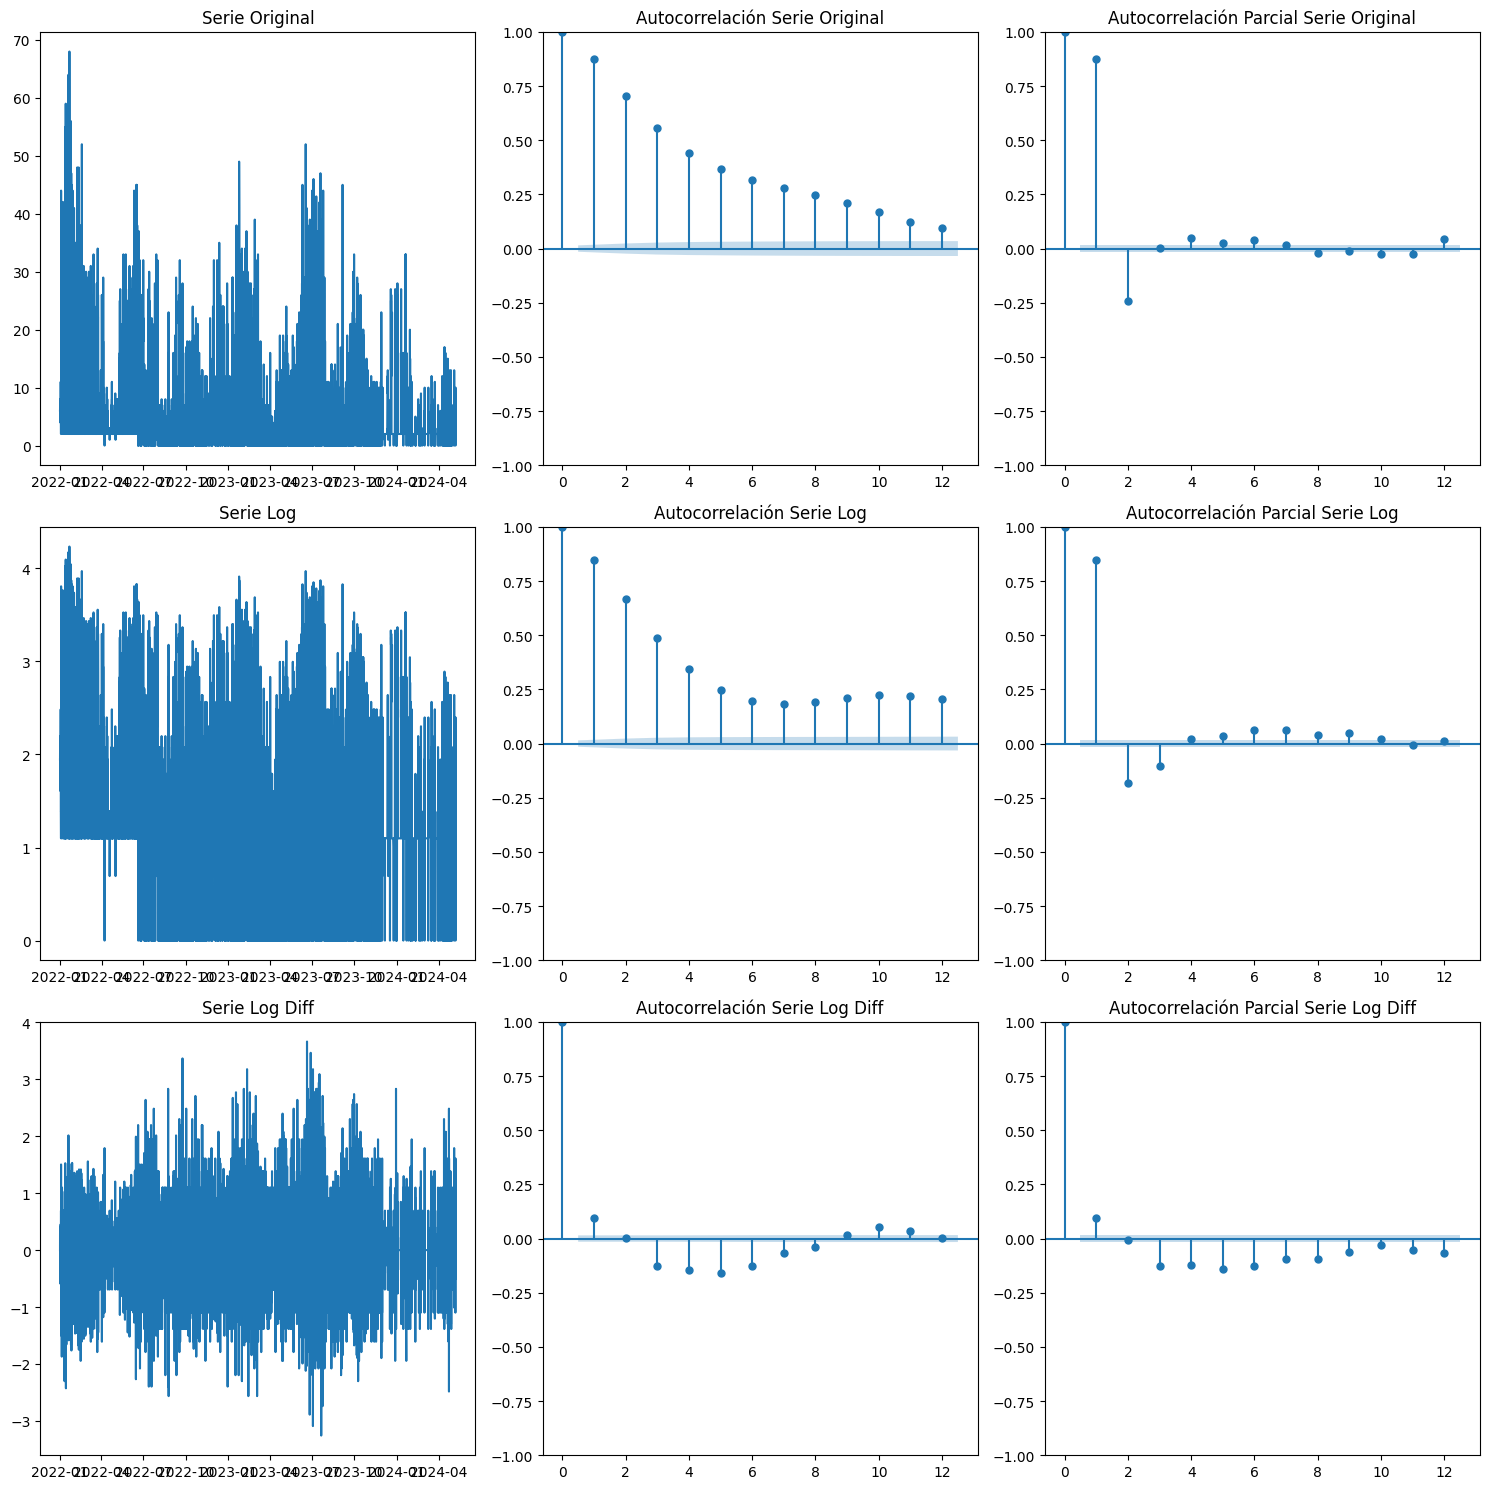

In [35]:
fig = plt.figure(figsize = (15, 15))

((ax11, ax12, ax13), (ax21, ax22, ax23), (ax31, ax32, ax33)) = fig.subplots(3, 3)

ax11.plot(df_x, df_y)
ax11.set_title("Serie Original")
plot_acf(df_y, ax = ax12, lags = LAGS, title = "Autocorrelación Serie Original")
plot_pacf(df_y, ax = ax13, lags = LAGS, title = "Autocorrelación Parcial Serie Original")

ax21.plot(df_x, df_y_log)
ax21.set_title("Serie Log")
plot_acf(df_y_log, ax = ax22, lags = LAGS, title = "Autocorrelación Serie Log")
plot_pacf(df_y_log, ax = ax23, lags = LAGS, title = "Autocorrelación Parcial Serie Log")

ax31.plot(df_x[1::], df_y_log_diff)
ax31.set_title("Serie Log Diff")
plot_acf(df_y_log_diff, ax = ax32, lags = LAGS, title = "Autocorrelación Serie Log Diff")
plot_pacf(df_y_log_diff, ax = ax33, lags = LAGS, title = "Autocorrelación Parcial Serie Log Diff")

fig.tight_layout()

# Gridsearch

In [36]:
# ts_to_predict_arima = df["df_y_log"]
df = df.asfreq('h')
ts_to_predict_arima = df.set_index("Date")["Consumo_log"]


In [37]:
y_train_arima = ts_to_predict_arima[:-10]
y_test_arima = ts_to_predict_arima[-10:]

In [38]:
pdq = [
    # el primer valor es la autocorrelacion parcial, el segundo de la cantidad de diff, el tercero autocorrelacion

    (1, 0, 1),
    (1, 0, 2),
    (1, 0, 3),
    (1, 0, 4),
    
    (24, 0, 1),
    (24, 0, 2),
    (24, 0, 3),
    (24, 0, 4),
    
    (1, 1, 1),
    (1, 1, 2),
    (1, 1, 3),
    (1, 1, 4),
    
    (24, 1, 1),
    (24, 1, 2),
    (24, 1, 3),
    (24, 1, 4), 

    (6, 1, 1),
    (6, 1, 2),
    (6, 1, 3),
    (6, 1, 4),
    
    (23, 1, 1),
    (23, 1, 2),
    (23, 1, 3),
    (23, 1, 4)]

seasonal_pdq = (0, 0, 0, 0)

In [39]:
df.head()

,Date,Consumo,Consumo_log,Consumo_log_diff
1970-01-01,NaT,NaN,NaN,NaN


In [40]:
RESULTS_DICT = {}

for param in pdq:

    model = sm.tsa.statespace.SARIMAX(
        endog = y_train_arima,
        order = param,
        seasonal_order = seasonal_pdq,
        enforce_stationarity = False, # porque ya es una serie estacionaria
        enforce_invertibility = False # porque ya es una serie estacionaria
    )

    model_fitted = model.fit(disp=False)

    print('ARIMA{}x{}12 - AIC:{}'.format(param, seasonal_pdq, model_fitted.aic))
    
    RESULTS_DICT[param] = round(model_fitted.aic, 2)

ARIMA(1, 0, 1)x(0, 0, 0, 0)12 - AIC:6.0
ARIMA(1, 0, 2)x(0, 0, 0, 0)12 - AIC:8.0
ARIMA(1, 0, 3)x(0, 0, 0, 0)12 - AIC:10.0


ARIMA(1, 0, 4)x(0, 0, 0, 0)12 - AIC:12.0


c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base

ARIMA(24, 0, 1)x(0, 0, 0, 0)12 - AIC:52.0
ARIMA(24, 0, 2)x(0, 0, 0, 0)12 - AIC:54.0


c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estima

ARIMA(24, 0, 3)x(0, 0, 0, 0)12 - AIC:56.0
ARIMA(24, 0, 4)x(0, 0, 0, 0)12 - AIC:58.0
ARIMA(1, 1, 1)x(0, 0, 0, 0)12 - AIC:6.0
ARIMA(1, 1, 2)x(0, 0, 0, 0)12 - AIC:8.0
ARIMA(1, 1, 3)x(0, 0, 0, 0)12 - AIC:10.0


c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estima

ARIMA(1, 1, 4)x(0, 0, 0, 0)12 - AIC:12.0
ARIMA(24, 1, 1)x(0, 0, 0, 0)12 - AIC:52.0
ARIMA(24, 1, 2)x(0, 0, 0, 0)12 - AIC:54.0
ARIMA(24, 1, 3)x(0, 0, 0, 0)12 - AIC:56.0


c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estima

ARIMA(24, 1, 4)x(0, 0, 0, 0)12 - AIC:58.0
ARIMA(6, 1, 1)x(0, 0, 0, 0)12 - AIC:16.0
ARIMA(6, 1, 2)x(0, 0, 0, 0)12 - AIC:18.0
ARIMA(6, 1, 3)x(0, 0, 0, 0)12 - AIC:20.0
ARIMA(6, 1, 4)x(0, 0, 0, 0)12 - AIC:22.0
ARIMA(23, 1, 1)x(0, 0, 0, 0)12 - AIC:50.0


c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:534: RuntimeWarning: invalid value encountered in scalar divide
  return -self.loglike(params, *args) / nobs
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e

ARIMA(23, 1, 2)x(0, 0, 0, 0)12 - AIC:52.0
ARIMA(23, 1, 3)x(0, 0, 0, 0)12 - AIC:54.0
ARIMA(23, 1, 4)x(0, 0, 0, 0)12 - AIC:56.0


c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estima

In [41]:
# gridsearch x y gridsearch y
gsx = list(map(str, list(RESULTS_DICT.keys())))
gsy = list(RESULTS_DICT.values())

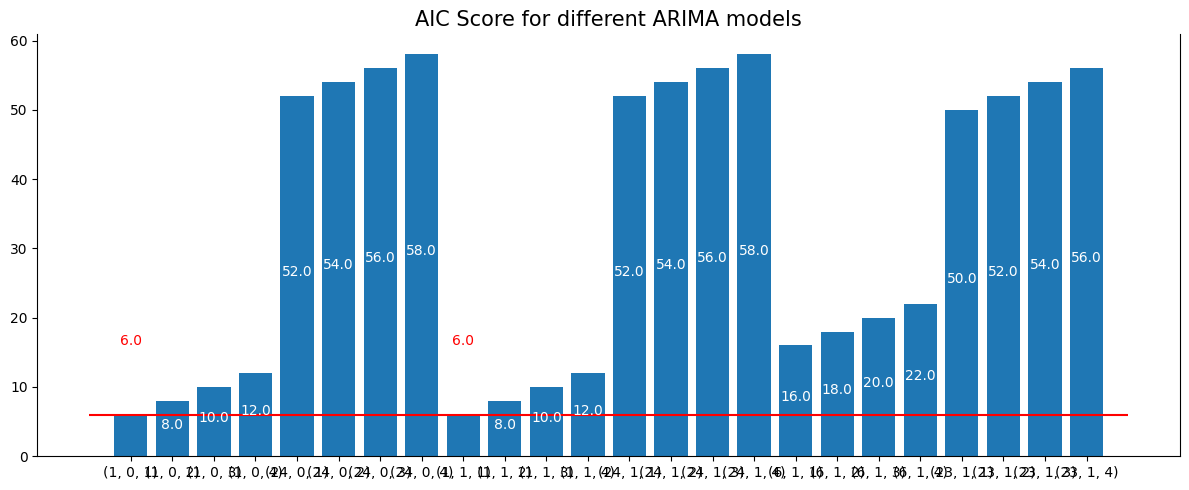

In [42]:
fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot()

ax.bar(x = gsx, height = gsy)
ax.hlines(y = min(gsy), xmin = -1, xmax = len(gsx), color = "red")

for xtick_, y_ in zip(gsx, gsy):
    
    s_ = str(round(y_, 2))
    
    ax.text(
        x = xtick_, 
        y = y_/2 if y_ != min(gsy) else y_ + 10, 
        s = s_, 
        ha = "center", 
        color = "red" if y_ == min(gsy) else "white"
    )

ax.spines["top"].set_color("None")

plt.title(label = "AIC Score for different ARIMA models", fontsize = 15)
plt.tight_layout()

In [43]:
idx_min_score_aic = np.argmin(list(RESULTS_DICT.values()))
pdq_min_score_aic = list(RESULTS_DICT.keys())[idx_min_score_aic]
min_score_aic = RESULTS_DICT[pdq_min_score_aic]

message = f'''
El score mínimo se alcanza con ARIMA{pdq_min_score_aic}
Con un score AIC de {min_score_aic}.
En la posición {idx_min_score_aic}
'''

print(message)


El score mínimo se alcanza con ARIMA(1, 0, 1)
Con un score AIC de 6.0.
En la posición 0



# Fit

In [44]:
best_arima_model = sm.tsa.statespace.SARIMAX(
    endog = y_train_arima,
    order = (1,0,1),#pdq_min_score_aic,
    seasonal_order = seasonal_pdq,
    enforce_stationarity = False,
    enforce_invertibility = False
)

best_arima_model_fitted = best_arima_model.fit()

c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base

In [45]:
print(best_arima_model_fitted.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0         -0        nan        nan           0           0
ma.L1               0         -0        nan        nan           0           0
sigma2         1.0000         -0       -inf      0.000       1.000       1.000


c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tools\eval_measures.py:415: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tools\eval_measures.py:440: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3015: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3015: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:472: RuntimeWarning: Mean of empty s

In [46]:
best_arima_model_fitted.plot_diagnostics(figsize = (15, 12), lags = 3);

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1500x1200 with 0 Axes>

In [ ]:
# Para hacer una predicción es suficiente con especificar el número de steps/pasos futuros a estimar.
pred_uc = best_arima_model_fitted.get_forecast(steps = len(y_test_arima))
y_pred_arima = pred_uc.predicted_mean

c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
y_pred_arima

0    0.0
dtype: float64

Text(0.5, 0.98, 'ARIMA Forecast')

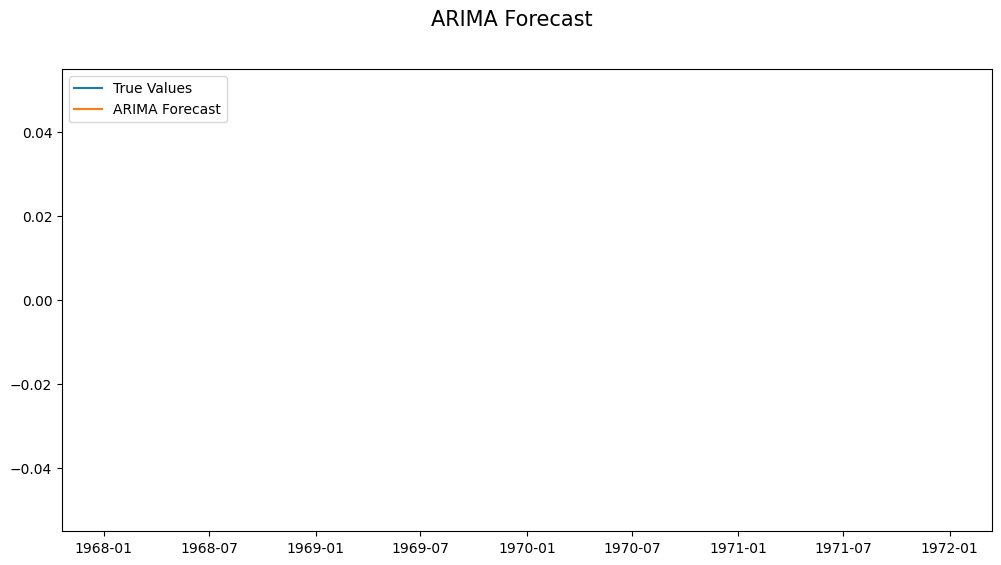

In [ ]:
fig = plt.figure(figsize = (12, 6))
ax = fig.subplots()

ax.plot(ts_to_predict_arima, label = "True Values")
ax.plot(y_pred_arima, label = "ARIMA Forecast")

ax.legend(loc = "upper left")
fig.suptitle("ARIMA Forecast", fontsize = 15)